### https://blog.csdn.net/weixin_44359288/article/details/136563477

In [ ]:
setwd('/import/hd/')

In [ ]:
sce = readRDS('./OA7.nno.rds')

In [ ]:
library(monocle)
library(Seurat)
library(tidyverse)
library(viridis)
library(RColorBrewer)
library(CellChat)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


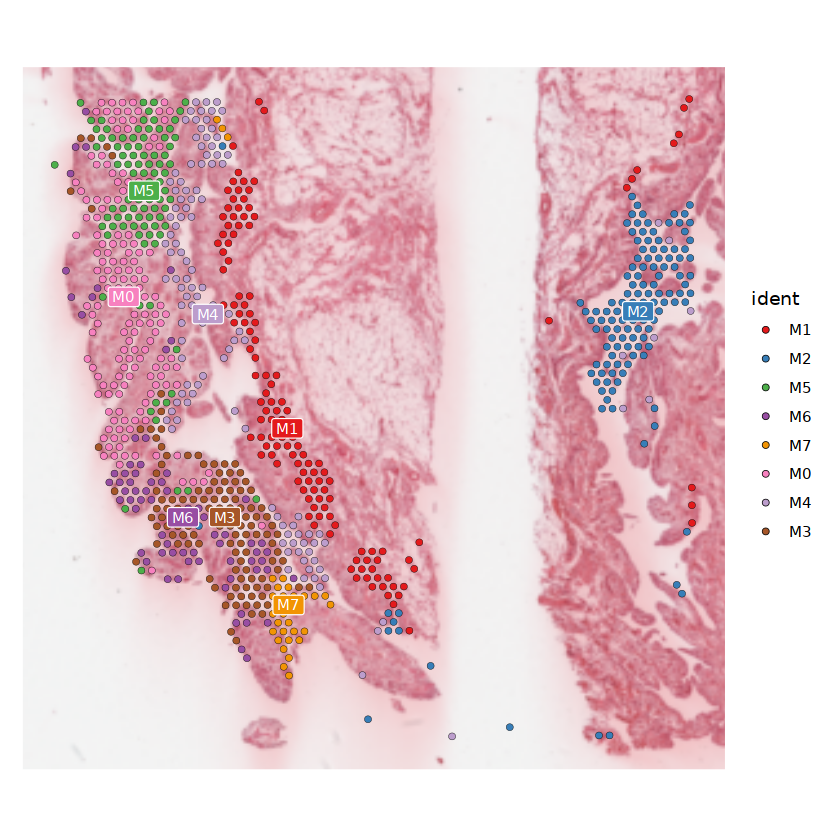

In [5]:
color.use <- scPalette(nlevels(sce))
names(color.use) <- levels(sce)
SpatialDimPlot(sce, label = TRUE, label.size = 3, cols = color.use)

In [19]:
table(sce$celltype)


 M0  M1  M2  M3  M4  M5  M6  M7 
154 133 129 122 119  95  72  32 

In [20]:
data.input = Seurat::GetAssayData(sce, slot = "data", assay = "SCT") 
#meta信息
meta = data.frame(labels = Idents(sce), #名字自定义
                  row.names = names(Idents(sce))) # manually create a dataframe consisting of the cell labels
unique(meta$labels)

[1] M1 M2 M5 M6 M7 M0 M4 M3
Levels: M1 M2 M5 M6 M7 M0 M4 M3

In [32]:
spatial.locs = Seurat::GetTissueCoordinates(sce, scale = NULL,cols = c("imagerow", "imagecol")) 
##scalefactors_json存于GBM4_spaceranger_out/spatial文件夹下
scalefactors = jsonlite::fromJSON(txt = file.path("/import/hd/OA7/spatial", 'scalefactors_json.json'))  
spot.size = 65 #10X Visium spot大小为55μm，两个spot之间Gap为10μm
conversion.factor = spot.size/scalefactors$spot_diameter_fullres
spatial.factors = data.frame(ratio = conversion.factor, tol = spot.size/2)
d.spatial <- computeCellDistance(coordinates = spatial.locs, ratio = spatial.factors$ratio, tol = spatial.factors$tol)

In [33]:
cellchat <- createCellChat(object = data.input, 
                           meta = meta, 
                           group.by = "labels", #定义的名字是labels
                           datatype = "spatial", #数据类型：空转
                           coordinates = spatial.locs, 
                           spatial.factors = spatial.factors)

[1] "Create a CellChat object from a data matrix"
Create a CellChat object from spatial transcriptomics data... 


Warning message in createCellChat(object = data.input, meta = meta, group.by = "labels", :
"The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`! 
"


Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  M1, M2, M5, M6, M7, M0, M4, M3 


The number of highly variable ligand-receptor pairs used for signaling inference is 1023 
truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on spatial transcriptomics data using distances as constraints of the computed communication probability <<< [2024-08-21 02:01:08]"
Molecules of the input L-R pairs are diffusible. Run CellChat in a diffusion manner based on the `interaction.range`.
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-08-21 04:41:59]"


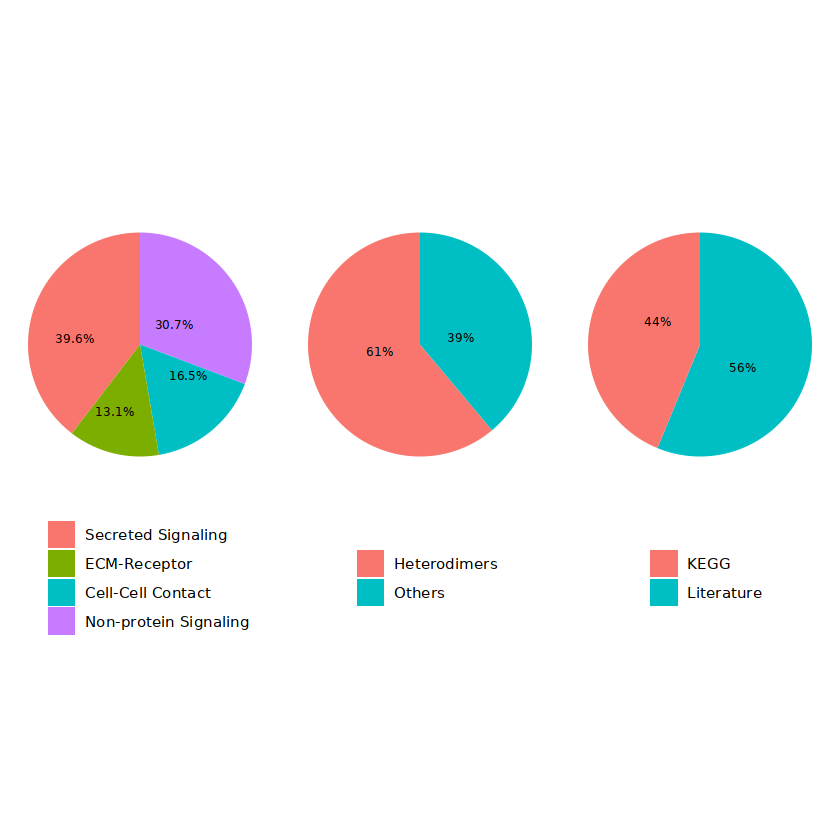

In [34]:
#设置参考数据库
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)
#使用CellChatDB的子集进行细胞间通信分析
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation") #选择Secreted Signaling
cellchat@DB <- CellChatDB.use
##CellChat预处理
cellchat <- subsetData(cellchat) # 即使使用整个数据库，此步骤也是必要的
future::plan("multisession", workers = 4) #多线程
#识别过表达基因
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat, variable.both = F)
##细胞间通信网络的推断
cellchat <- computeCommunProb(cellchat, type = "truncatedMean", trim = 0.1,
                              distance.use = TRUE, interaction.range = 250, scale.distance = 0.01,
                              contact.dependent = TRUE, contact.range = 100)

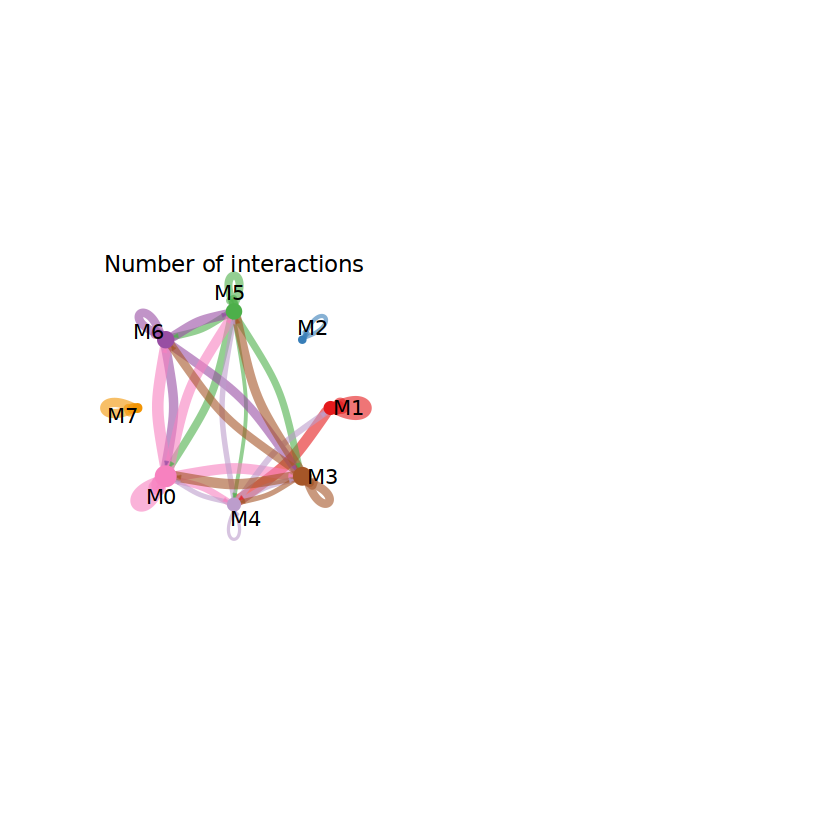

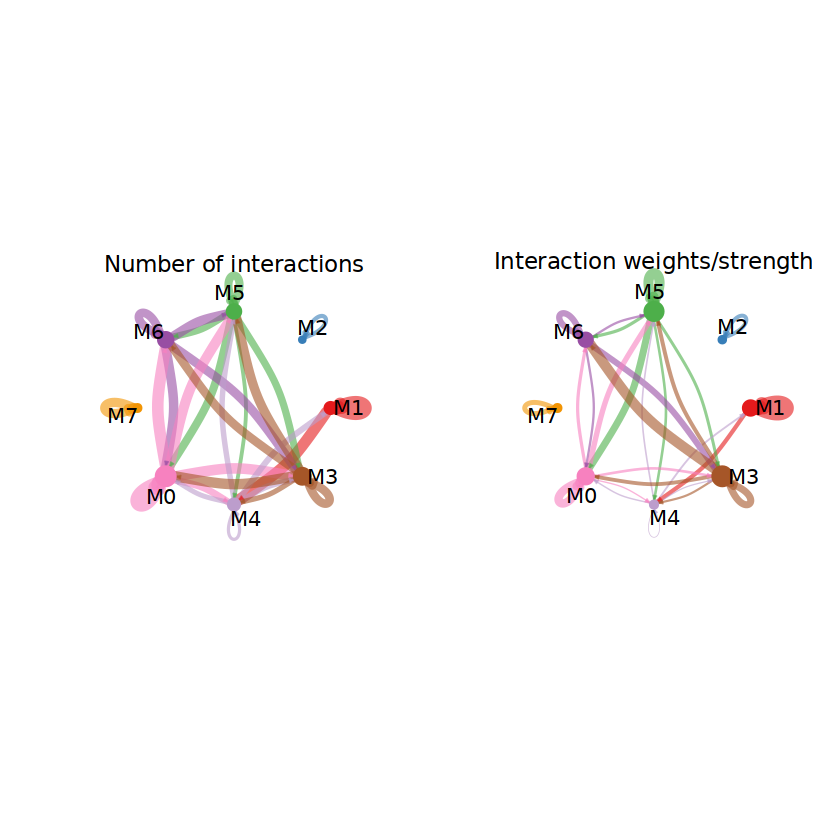

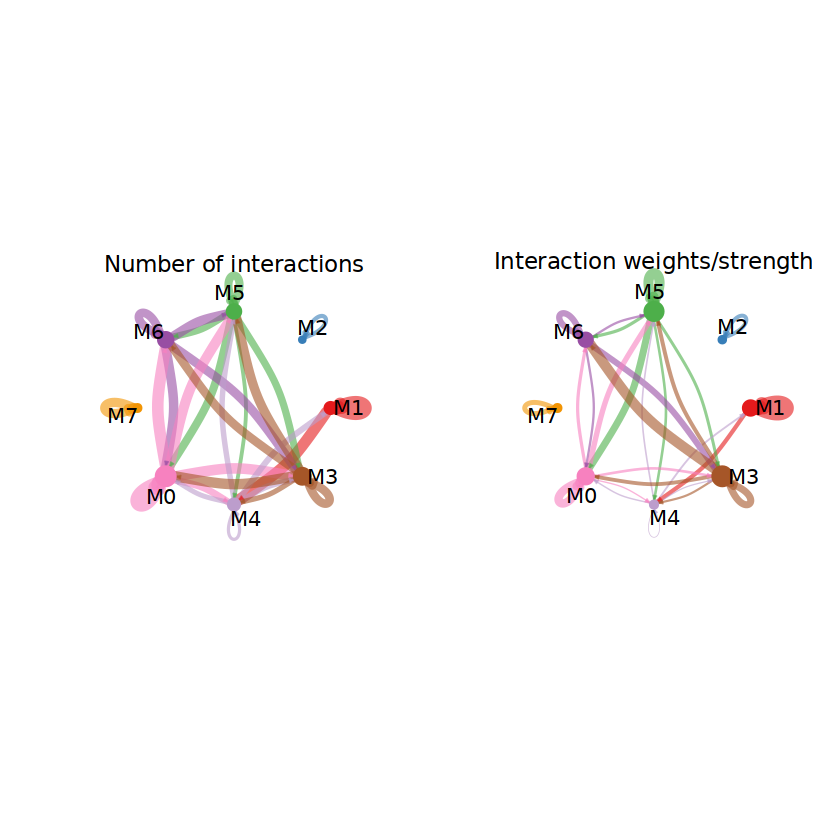

In [35]:
#默认情况下，每个细胞组中用于细胞间通信所需的最小细胞数为10
cellchat <- filterCommunication(cellchat, min.cells = 10)
 
#在信号通路水平上推断细胞间通讯
cellchat <- computeCommunProbPathway(cellchat)
 
#计算聚合的 cell-cell 通信网络
cellchat <- aggregateNet(cellchat)
 
#显示交互次数或总交互次数 
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = rowSums(cellchat@net$count), weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = rowSums(cellchat@net$weight), weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

Do heatmap based on a single object 


Do heatmap based on a single object 




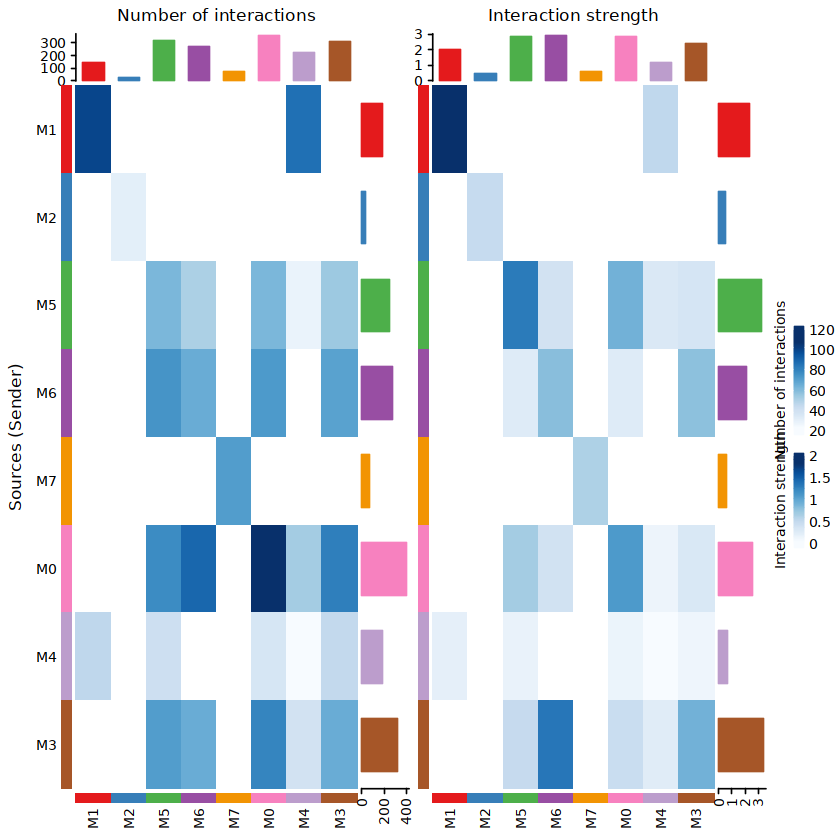

In [36]:
#显示celltype间的通讯次数（左）或总通讯强度(右)
p1 <- netVisual_heatmap(cellchat, measure = "count", color.heatmap = "Blues")
p2 <- netVisual_heatmap(cellchat, measure = "weight", color.heatmap = "Blues")
p1 + p2

[1] "SEMA3"       "ANGPTL"      "CXCL"        "SPP1"        "EGF"        
 [6] "GAS"         "CSF"         "ANNEXIN"     "GALECTIN"    "PTN"        
[11] "MIF"         "COMPLEMENT"  "PERIOSTIN"   "PLAU"        "CypA"       
[16] "ncWNT"       "PDGF"        "FGF"         "VEGF"        "TGFb"       
[21] "MK"          "CCL"         "BMP"         "ACTIVIN"     "CALCR"      
[26] "TNF"         "IGFBP"       "ADIPONECTIN" "IL16"        "PROS"       
[31] "GDF"         "TWEAK"       "BRADYKININ"  "GRN"         "CHEMERIN"   
[36] "IL10"        "SLIT"        "VEGI"        "VISFATIN"    "PROCR"      
[41] "PARs"        "PROC"        "IL1"         "EDN"         "HGF"        
[46] "TULP"        "TRAIL"       "IGF"         "IL4"         "NRG"        
[51] "CX3C"        "WNT"         "AGT"         "APELIN"      "SLURP"      
[56] "LIGHT"       "SLITRK"      "MHC-I"       "RBP4"        "IFN-I"      
[61] "CTSG"        "HH"          "NT"          "CD40"        "RANKL"      
[66] "ANGPT"       "GPR"         "KIT"         "PTH"         "FASLG"      
[71] "RLN"         "NPW-B"       "NPR1"        "IL2"

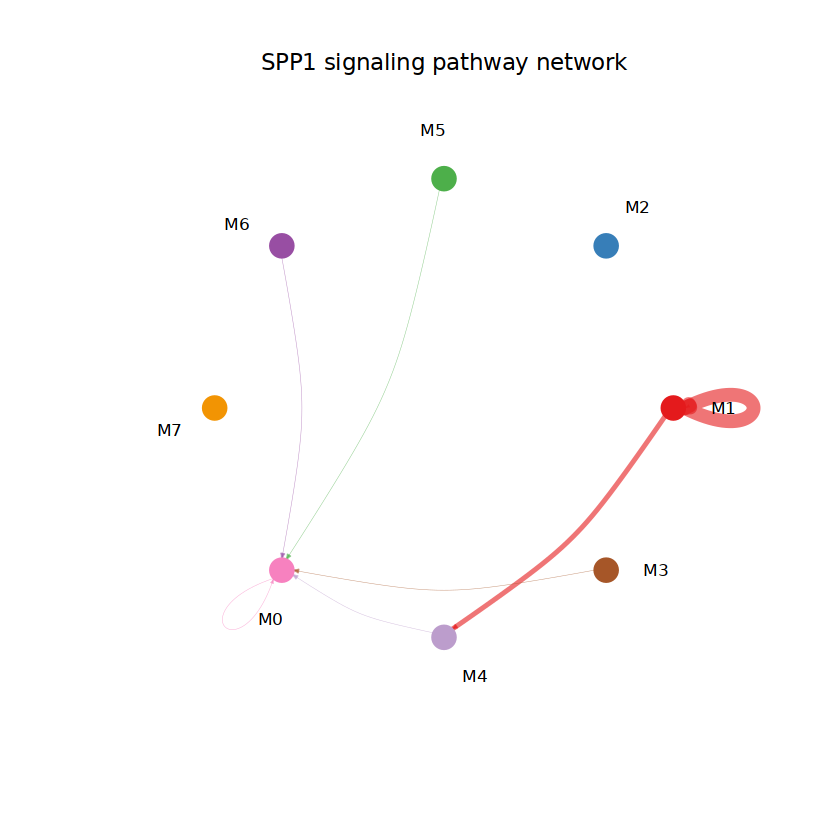

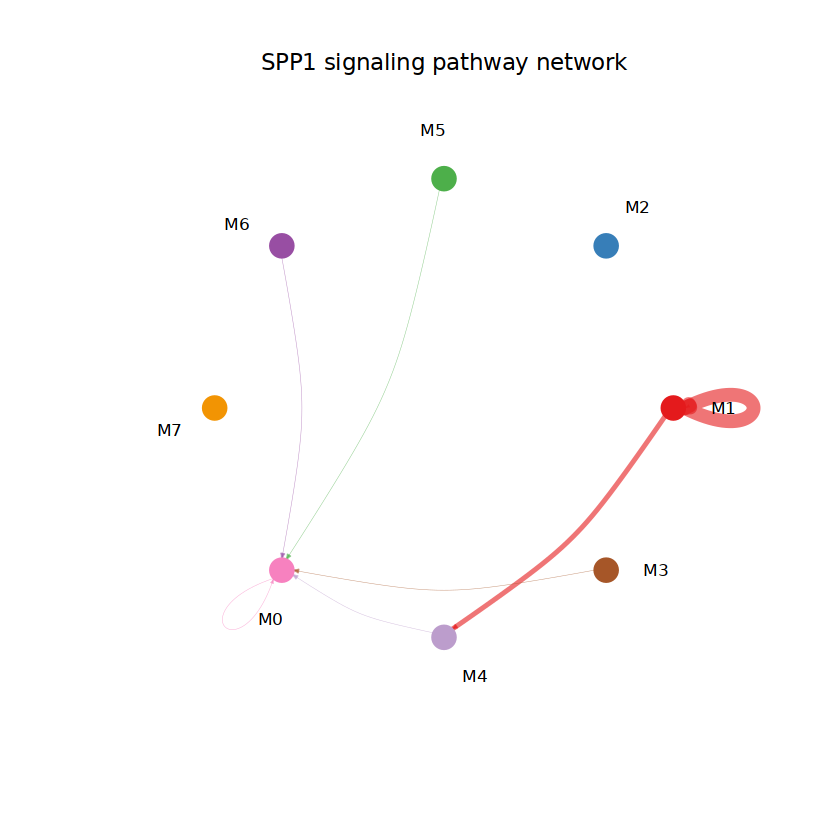

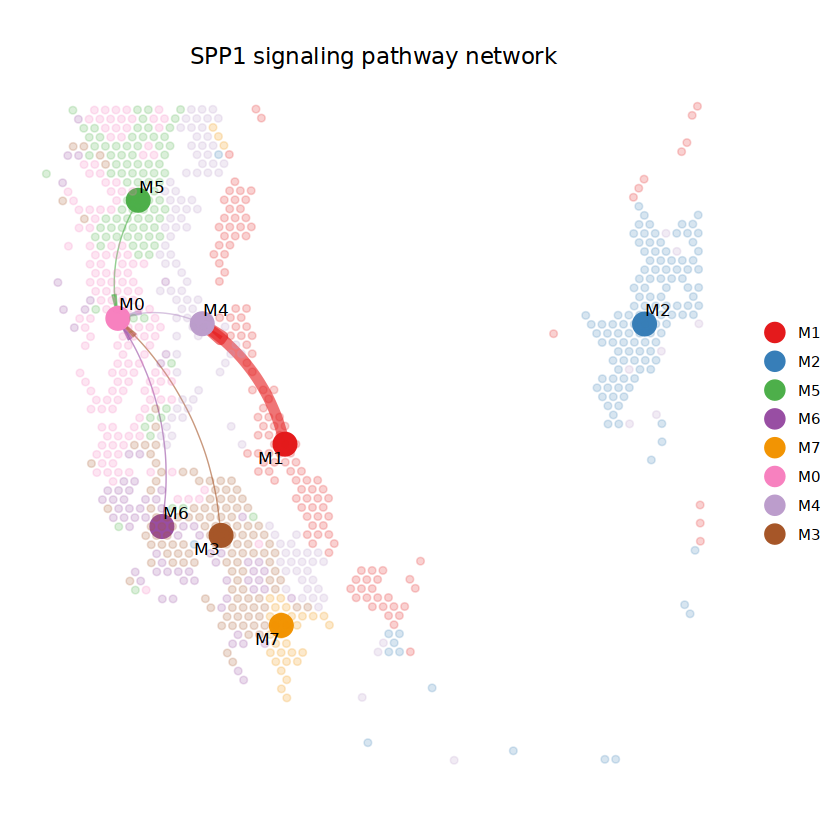

In [37]:
#展示显著通路结果
cellchat@netP$pathways
 #[1] "SPP1"         "PTN"          "MIF"          "MK"           "CypA"         "IGFBP"        
 #"ANGPTL"      
 #[8] "VEGF"         "GRN"          "PSAP"         "SEMA3"        "BMP"          "FGF"          
 #"VISFATIN"......
 
par(mfrow=c(1,1), xpd = TRUE)# xpd = TRUE以显示标题
pathways.show <- c("SPP1")
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")
 
#在空间转录组学上显示信号网络
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "spatial", edge.width.max = 2,vertex.size.max = 1, alpha.image = 0.2, vertex.label.cex = 3.5)

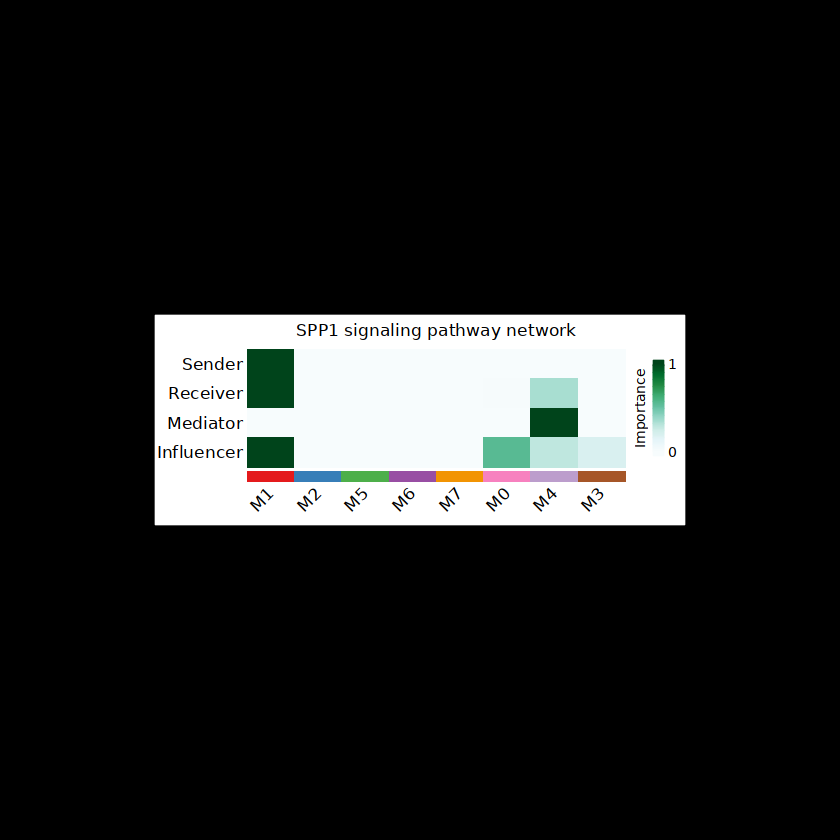

In [38]:
#计算和可视化网络中心性分数：
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")#“netP”是指推断的信号通路的细胞间通信网络
 
par(mfrow=c(1,1))
netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, width = 8, height = 2.5, font.size = 10)